In [ ]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization to /tmp/pip-req-build-o4ibn_jq
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization /tmp/pip-req-build-o4ibn_jq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 298 kB 49.0 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=144999 sha256=cd96b21458e904fb54d7589b0c14b3880f375a45cca7b21e325f1451d3fcc6ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-fexe9st_/wheels/eb/7f/26/4a3835d3d83e17ac1d9bed33d09ecdd6dd423759b38e69c270
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=a50735c0aaba79db68ce6089911012505d6b61fb165107b3a827079eb8bc0ac4
  Stored in directory

In [ ]:
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 29.7 MB/s 


In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F10, F11, F12, F13, F14, F15, F16, F21

In [29]:
dim = 2
lb, ub = -5, 5

space = RealSpace([lb, ub]) * dim

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

doe_sizes = (5, 10, 15, 20)
max_FEs = 50
verbose = False

n_samples = 1000

max_cma_iter = 10

In [62]:
opt_color, found_color, initial_color = "green", "red", "blue"


def plot(points, colors, ax=plt, outline=False, marker='o'):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker)
  
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

def plot_one_function(func, samples, values, results):
    fig, axs = plt.subplots(1, len(results))
    fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
    for (result, ax) in zip(results, axs):
        plot_result(func, samples, values, result, ax)
    plt.show()

In [18]:
def make_optimizer(obj_func, doe):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )
    
def regret_function(obj_func, doe_size):
    def func(X):
        doe = np.split(X, doe_size)
        opt = make_optimizer(obj_func, doe)
        _, value, _ = opt.run()
        return value - obj_func.getfopt()
    return func

## Experiments

In [70]:
sigma0 = ub / 3 # the optimum is expected to lie within x0 +- 3 * sigma0

def cma_es_experiment(obj_function, doe_size):
  regret_func = regret_function(obj_function, doe_size)
  doe_flattened, es = cma.fmin2(regret_func, np.zeros(doe_size * dim), sigma0, {'maxiter': max_cma_iter})
  doe = np.split(doe_flattened, doe_size)
  opt = make_optimizer(obj_function, np.split(es.best.x, doe_size))
  x, value, _ = opt.run()
  samples = space.sample(n_samples)
  values = obj_function(samples)
  regret = value - obj_function.getfopt()
  print(f'Regret is: {regret}, Found x: {x}, Found f: {value}, Optimal f: {obj_function.getfopt()}, Optimum x: {obj_function._xopt}')
  plot_result(obj_func, samples, values, {"initial_points": np.array(doe), "regret": regret, "found_x": x}, plt.gca())

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=93957, Mon Oct 17 19:33:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.861922798371609e-03 1.0e+00 1.53e+00  1e+00  2e+00 1:19.6
    2     20 2.370184363797989e-05 1.2e+00 1.49e+00  1e+00  2e+00 2:41.2
    3     30 2.480250783065685e-05 1.3e+00 1.70e+00  2e+00  2e+00 4:07.9
    4     40 7.985293898116197e-06 1.3e+00 1.96e+00  2e+00  2e+00 5:28.5
    5     50 3.063473255430438e-03 1.4e+00 2.11e+00  2e+00  2e+00 6:49.3
    6     60 4.271533740855205e-03 1.4e+00 2.15e+00  2e+00  2e+00 8:15.4
    7     70 3.893948259023716e-02 1.4e+00 2.00e+00  2e+00  2e+00 9:36.5
    8     80 1.151745493430667e-04 1.4e+00 1.88e+00  2e+00  2e+00 11:03.7
    9     90 1.945334062725124e-07 1.5e+00 1.73e+00  1e+00  2e+00 12:26.2
   10    100 7.048383350749532e-04 1.4e+00 1.58e+00  1e+00  2e+00 13:47.3
termination on maxiter=10 (Mon Oct 17 19:47:48 2022)
final/bestever f-value = 1.370534e+00 1.945334e-07


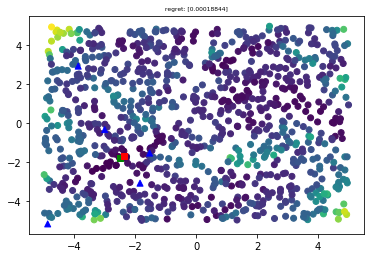

In [71]:
obj_func = F21(1)
doe_size = 5

cma_es_experiment(obj_func, doe_size)